In [41]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import datetime
import re
import os
import glob
import math
import gc
import shutil

from config import config
import YJ_assistant

In [42]:
TRAIN_MODE = True

OPERATION = 'PRETRAIN'  # 'PRETRAIN'  'TRAIN_C'   'FINETUNE'   'TEST', 'BACKTEST'

MODEL_ID = 'YJ.01' # 'YA.11'
HISTORY_LEN = 400
SEQ_YEAR_SPAN = 15
NOTE = 'R_MAPTEST'

DATA_THEME = str(HISTORY_LEN).zfill(3) + '-' + str(SEQ_YEAR_SPAN).zfill(2) + '-' + NOTE
COPY_IDS_DS_DATA_FROM = None  # "_DATA_400-15-Test"  None

STARTING_PERCENT = 0
ENDING_PERCENT = 0
TRAIN_PERCENT= 96
VALID_PERCENT = 4
TEST_PERCENT = 100 - TRAIN_PERCENT - VALID_PERCENT

BATCH_SIZE = 25 # 25 for headers 6.

TEAM_EMBS = 50  #
DECODE_BASE_DATE = False
EMBED_AB_COLS = False    # True: Pls choose a small LR so that we have plenty of train epochs and the embedded values have enough chance to seek their proper places.
ODDS_IN_ENCODER = False   #--------------
ODDS_IN_DECODER = True
ADDITIONAL_D_MODEL = 0   #------------ Try increase it when underfitting.

TRANSFORMER_LAYERS = 30        #----------30
TRANSFORMER_HEADS = 6
BALANCE_POS_CODE = True        # True: Weakens positional code compared to embedded values.
DROPOUT = 0.0  # 0.1
ADAPTORS_LAYERS = 0 #------------ 10
ADAPTORS_WIDTH_FACTOR = 30  # 30

# This is an exponential curve that hits STARTING_LEARNING_RATE at step zero and EXAMPLE_LEARNING_RATE at step EXAMPLE_LEARNING_STEP.
# lr(step) = STARTING_LEARNING_RATE * pow( pow(EXAMPLE_LEARNING_RATE/STARTING_LEARNING_RATE, 1/EXAMPLE_LEARNING_STEP), step )
STARTING_LEARNING_RATE = 5e-7
EXAMPLE_LEARNING_RATE = STARTING_LEARNING_RATE * 0.5    #------------ 0.5 worked.
EXAMPLE_LEARNING_STEP = 100

MODEL_ACTIVATION = 'softmax'    # 'softmax', 'sigmoid', 'relu', 'open'
LOSS_TYPE = 'profit'           # 'profit', 'entropy'
VECTOR_BETTING = False
STAKE_TECHNIQUE = 'independent'         # 'independent', 'majority', 'riskest'

MODEL_TYPE_CHECK = False
GET_VAL_LOSS_0 = False
IGNORE_HISTORY = False
SIMPLIFY_ADAPTOR = True
NUMBER_QUERIES = 3

In [43]:
COUNTRY = 'England'
NUMBER_BOOKIES = 5  # Take William Hills, Bet&Win, and Bet365. Other bookies' odds list change over years and leagues.
PREFERED_ORDER = ['B365', 'WH']   # Implies the order only.
BOOKIE_TO_EXCLUDE = []    # 'BWIN' odds don't show up since mid Febrary 2025. This may reduce the effective NUMBER_BOOKIES.
DIVIISONS = ['E0', 'E1', 'E2', 'E3']    # 'EC', the Conference league, is excluded as some odds makers are not archived for the league since 2013.
REPEATING_BOOKIE = None    #-----------------------------------

"""
#-------------------- England ---------------------
Time range of data: 2004/2005 - 2024/2025
Leagues - Premiere, League 1, League 2, Championship, Conference (dropped out)
!!! Conference will be dropped out because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.
Bookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed
William Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league
William Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship
William Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1
William Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2
William Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league
BWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-14
"""

# COUNTRY = 'Scotland'
# NUMBER_BOOKIES = 3  # Take ...

'\n#-------------------- England ---------------------\nTime range of data: 2004/2005 - 2024/2025\nLeagues - Premiere, League 1, League 2, Championship, Conference (dropped out)\n!!! Conference will be dropped out because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.\nBookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed\nWilliam Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league\nWilliam Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship\nWilliam Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1\nWilliam Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2\nWilliam Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league\nBWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-1

In [44]:
ODDS_COLS = []
for b in range(NUMBER_BOOKIES):
    ODDS_COLS += ['HDA'+str(b)+'H', 'HDA'+str(b)+'D', 'HDA'+str(b)+'A']

In [45]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ODDS_COLS
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols
Required_Non_Odds_cols = Div_cols + Date_cols + Team_cols + Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols

# Make sure Odds_cols comes first !!!
_Cols_to_Always_Normalize = Odds_cols

_Label_cols = Full_Goal_cols + Odds_cols

bbab_odds_start = BBAB_cols.index(Odds_cols[0])
bb_odds_start = BB_cols.index(Odds_cols[0])
label_odds_start = _Label_cols.index(Odds_cols[0])

In [46]:
history_folder = os.path.join('.', 'history')
country_folder = os.path.join('.', "data", "football-data-co-uk", COUNTRY)
gameHistory_folder_path = os.path.join(country_folder, 'Game_History')
if not os.path.exists(gameHistory_folder_path): os.makedirs(gameHistory_folder_path, exist_ok=False)
countryTheme_folder_path = os.path.join(country_folder, '_DATA_' + DATA_THEME)
if not os.path.exists(countryTheme_folder_path): os.makedirs(countryTheme_folder_path, exist_ok=False)
map_folder_path = os.path.join(countryTheme_folder_path, '_id_map')     # do not change to '_map' for backward compatibility
if not os.path.exists(map_folder_path): os.makedirs(map_folder_path, exist_ok=False)
dataset_foler_path = os.path.join(countryTheme_folder_path, '_dataaset')    # keep '_dataaset' as it for backward compatibility
if not os.path.exists(dataset_foler_path): os.makedirs(dataset_foler_path, exist_ok=False)
checkpoint_folder_path = os.path.join(country_folder, '_checkpoints')
if not os.path.exists(checkpoint_folder_path): os.makedirs(checkpoint_folder_path, exist_ok=False)
tokenizer_folder_path =  os.path.join(countryTheme_folder_path, '_tokenizer')
if not os.path.exists(tokenizer_folder_path): os.makedirs(tokenizer_folder_path, exist_ok=False)
map_filename_base = DATA_THEME
dataset_path = os.path.join(dataset_foler_path, map_filename_base + '-foundation-ds')

In [47]:
#========================= CREATE_DADAFRAMES_v2 =============================

skip = True
YJ_assistant.assign_seasonal_filenames(gameHistory_folder_path)
df_train, df_new = YJ_assistant.CREATE_DADAFRAMES_v2(gameHistory_folder_path, countryTheme_folder_path, Required_Non_Odds_cols, NUMBER_BOOKIES, oddsGroupsToExclude = BOOKIE_TO_EXCLUDE, preferedOrder = PREFERED_ORDER, train_mode = TRAIN_MODE, skip=skip)
print("df_train: ", df_train.shape)
print("df_new: ", df_new.shape)

files found to rename:  0
df_train:  (42229, 38)
df_new:  (0, 38)


In [48]:
div_list = list(df_train['Div']); home_list = list(df_train['HomeTeam']); away_list = list(df_train['AwayTeam'])
unique_divs = set(div_list)

teams_by_div = { div : set([team for team in home_list if div_list[home_list.index(team)]==div]).union(set([team for team in away_list if div_list[away_list.index(team)]==div])) for div in unique_divs }
for div1 in unique_divs:
    for div2 in unique_divs:
        if div1 != div2:
            assert teams_by_div[div1].intersection(teams_by_div[div2]) == set()
teams_by_div = { div: list(teams) for (div, teams) in teams_by_div.items()}


In [49]:
import networkx as nx
import copy


def CREATE_MAP_v1(folder, idMap_filename, targetLength, df_sequence, df_base, year_span, testcount=-1, to_save=True):

        def find_Electric_Flow_On_Connected_Graph(graph, source, target, inpuCurrent):
                '''
                Find the flow of electric current on each edge of 'graph' when total flow of 1.0 flows from 'source' to 'target' nodes,
                with conductance of edges stored in edge['conductance'].
                1. If 'source' and 'target' nodes are disconnected with each other, WEIRD amounts on flows on edges.
                2. If 'source' and 'target' nodes have zero conductance between them, it produces WEIRD amount of flows that violate Kirchhoff's law.
                '''
                edges = [e for e in graph.edges]        # (u, v) either u < v or u < v.
                nodes = [v for v in graph.nodes]
                edges_signs = []
                for v in nodes:
                        # We want the orientation of an edge (u, v) to be from min(u, v) to max(u, v)
                        edges_v = [(v, u) for u in nodes if (v, u) in graph.edges]      # all edges that have v as its node, in the form of (v,u)
                        edges_v_plus = [(v, u) for (v, u) in edges_v if v > u]          # (v, u < v)
                        edges_v_minus = [(v, u) for (v, u) in edges_v if v < u]         # (v, u >= v)
                        edges_v_plus = [(edges.index((u, v)) if edges.count((u, v)) > 0 else edges.index((v, u))) for (u, v) in edges_v_plus]
                        edges_v_minus = [(edges.index((u, v)) if edges.count((u, v)) > 0 else edges.index((v, u))) for (u, v) in edges_v_minus]
                        edges_signs.append((edges_v_plus, edges_v_minus))
                matrix_B = [ [ (1 if e in edges_signs[v][1] else -1 if e in edges_signs[v][0] else 0) for e in range(len(edges)) ] for v in range(len(nodes))]
                matrix_B = np.array(matrix_B, dtype=np.float32)
                vector_C = np.array( [graph.edges[e]['conductance'] for e in edges], dtype=np.float32)
                matrix_C = np.diag(vector_C)
                matrix_L = np.dot(np.dot(matrix_B, matrix_C), matrix_B.T)
                inverse_L = np.linalg.pinv(matrix_L, hermitian=True)    # Moore-Penrose pseudo-inverse
                # inverse_L = np.linalg.inv(matrix_L)
                source_node = nodes.index(source)
                target_node = nodes.index(target)
                X_vector = np.zeros((len(nodes),), dtype=np.float32)
                X_vector[source_node] = inpuCurrent
                X_vector[target_node] = - inpuCurrent
                flows = np.matmul(matrix_C, matrix_B.T)
                flows = np.matmul(flows, inverse_L)
                flows = np.matmul(flows, X_vector)

                return flows, nodes, edges   # nodes and edges, just in case list(graph.nodes) might have different order each time.

        def find_nTotalGames(gameGraph):
                nTotalGames = 0
                for e in gameGraph.edges:   nTotalGames += len(gameGraph.edges[e]['games'])
                return nTotalGames

        def reachable(graph, u, v):
                _reachable = True
                try:    nx.shortest_path_length(graph, u, v)
                except: _reachable = False
                return _reachable

        def isConnected(gameGraph):
                connected = True
                for u in gameGraph.nodes:
                        for v in gameGraph.nodes:
                                if not reachable(gameGraph, u, v):
                                        connected = False
                                        break
                return connected

        def create_conducting_game_graph_uk(game_list, baseDate, conductance365):
                # game_list is sorted in (date, div).
                alpha = pow(conductance365, 1/365)     # conductance365 < 1
                def conductance(_date):
                        daysAgo = (baseDate - _date).days       # > 0
                        return pow(alpha, daysAgo)             # pow(conductance365, daysAgo/365) <= 1, as conductance365 < 1
                
                graph = nx.Graph()
                for id, div, home, away, dt in game_list:
                        if (home, away) not in graph.edges:
                                graph.add_edge(home, away)
                                graph.edges[home, away]['games'] = []
                        graph.edges[home, away]['games'].append((id, dt, conductance(dt)))

                for edge in graph.edges:
                        games = graph.edges[edge]['games']
                        edge_con = 0.0
                        for (_, _, con) in games: edge_con += con
                        graph.edges[edge]['conductance'] = edge_con

                return graph


        def find_games(gameGraph):
                games = []
                for e in gameGraph.edges:   games += [id for (id, date, con) in gameGraph.edges[e]['games']]
                return games

        def try_remove_lowest_flow_games(gameGraph, eFlows, edges, targetLength):
                # Eithe isConnected(gameGraph) or not. This call worsens it by removing some edges.
                emptyPairs = []
                currents = []
                for (teamA, teamB) in gameGraph.edges:  # May not: teamA < teamB
                        # get the current on the edge (teamA, teamB)
                        eId = (edges.index((teamA, teamB)) if edges.count((teamA, teamB)) > 0 else edges.index((teamB, teamA))) # Exists
                        flow = abs(eFlows[eId])
                        
                        if len(gameGraph.edges[teamA, teamB]['games']) <= 0:
                                emptyPairs.append((teamA, teamB))
                        else:
                                edge_conductance = gameGraph.edges[teamA, teamB]['conductance'] # Asserted positive, no need epsilon.
                                currentPerUnitCon = flow / edge_conductance
                                pair_games = gameGraph.edges[teamA, teamB]['games']     # Creates a set of pair expressions.
                                pair_current = [(currentPerUnitCon * cond, id, date, cond, teamA, teamB) for (id, date, cond) in pair_games]
                                currents += pair_current

                # Note: Pair representations (A, B) in currents came from [for (A, B) in gameGraph.edges]
                for (teamA, teamB) in emptyPairs:   gameGraph.remove_edge(teamA, teamB)
                assert find_nTotalGames(gameGraph) == len(currents)

                # sort currents in (curr / descending, date / descending )
                currents = [(date, curr, id, cond, teamA, teamB) for (curr, id, date, cond, teamA, teamB) in currents]
                currents.sort(reverse=True)     # later dates come first
                currents = [(curr, id, date, cond, teamA, teamB) for (date, curr, id, cond, teamA, teamB) in currents]
                currents.sort(reverse=True)    # larger current comes first

                if len(currents) <= targetLength:   pass
                else:
                        # Either zero-current edges survive or positive-current edges are removed by this cut, both leading to disconnected graph. 
                        currents = currents[ : targetLength ]   # note currents are sorted in (curr, date)
                        pairsChanged = []
                        #-----------------------------------------------------------------------------------------------------
                        #   Below, 'currents' is reflected to gameGraph. No more pairs/games are removed, except that.
                        #-----------------------------------------------------------------------------------------------------

                        #======== Find <which games on which pair> are in 'currents'
                        pairsInCurrents = list(set([(teamA, teamB) for (_,_,_,_, teamA, teamB) in currents]))
                        gamesByPairInCurrents = [ ( (teamA, teamB), [(id, date, con) for (_, id, date, con, _teamA, _teamB) in currents 
                                if _teamA == teamA and _teamB == teamB ] )      # currents and pairs_from_current share the same expressions of pair.
                                for (teamA, teamB) in pairsInCurrents]       # May not: teamA < teamB

                        #========= Remove existing pairs that are not in pairsInCurrents, that has no game at all in currents.
                        allPairs = [(teamA, teamB) for (teamA, teamB) in gameGraph.edges]   # Pair representatoin comes from [for (A, B) in gameGraph.edges]
                        pairsToRemove = [(teamA, teamB) for (teamA, teamB) in allPairs if (teamA, teamB) not in pairsInCurrents]
                        for (teamA, teamB) in pairsToRemove:  gameGraph.remove_edge(teamA, teamB)

                        #========= Replace existing games of pairsInCurrents with games found in 'currents' if appropriate.  
                        for ((teamA, teamB), games) in gamesByPairInCurrents:
                                if len(gameGraph.edges[teamA, teamB]['games']) != len(games):   # if some games were excluded.
                                        gameGraph.edges[teamA, teamB]['games'] = games  # Replace.
                                        pairsChanged.append((teamA, teamB))

                        #========= Update nTotalGames
                        nTotalGames = find_nTotalGames(gameGraph)
                        assert nTotalGames == targetLength

                return gameGraph, nTotalGames, pairsChanged, currents

        NOISE_RATE = 1/100      # Successful test chose 1/100.

        def get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365):
                games = []; report = 0
                if len(div_sub_list) <= history_len:
                        games = [id for (id, _, _, _, _) in div_sub_list]
                        report = 10
                else:
                        dgg = create_conducting_game_graph_uk(div_sub_list, base_date, conductance365=conductance365)   # MUCH faster than transform_to_conducting_graph

                        if reachable(dgg, home, away):
                                flows, nodes, edges = find_Electric_Flow_On_Connected_Graph(dgg, home, away, inputCurrent)
                                flows_copy = copy.deepcopy(flows)
                                flows_copy = [abs(f) for f in flows_copy]
                                flows_copy.sort(reverse=True)

                                if  flows_copy[0] > inputCurrent * NOISE_RATE:
                                        # Now, either isConnected(dgg) or not. This call worsens it by removing some edges.
                                        dgg, nTotalGames, pairsChanged, currents = try_remove_lowest_flow_games(dgg, flows, edges, history_len)
                                        games = find_games(dgg)
                                        assert len(games) == history_len
                                        report = 20
                                else:
                                        games = [id for (id, div, home, away, dt) in div_sub_list[- history_len : ]]  # collect latest ids
                                        report = 30

                        else: # Very rare. Few games are new edge in the conductance graph after collecting at lease HISTORY_LEN past games in the graph. They might be inter-league games.
                                # find_Electric_Flow_On_Connected_Graph(.) doesn't work here.
                                games = [id for (id, _,_,_,_) in div_sub_list[- history_len : ]]   # collect latest ids
                                report = 40

                return games, report
     
        def get_historical_games(base_id, base_date, base_div, home, away, sub_list, history_len, inputCurrent, conductance365):
                flows_0 = nodes_0 = edges_0 = None

                games = []; report = None
                if len(sub_list) <= history_len:
                        games = [id for (id, _, _, _, _) in sub_list]      # better than dummy games.
                        report = 100
                else:
                        gg = create_conducting_game_graph_uk(sub_list, base_date, conductance365=conductance365)   # MUCH faster than transform_to_conducting_graph

                        if reachable(gg, home, away):
                                flows_0, nodes_0, edges_0 = find_Electric_Flow_On_Connected_Graph(gg, home, away, inputCurrent)
                                flows_abs = copy.deepcopy(flows_0)
                                flows_abs = [abs(f) for f in flows_abs]
                                flows_abs.sort(reverse=True)

                                if  flows_abs[0] > inputCurrent * NOISE_RATE: # No other way to find the e flow problem was successful.
                                        # Now, either isConnected(dgg) or not. This call worsens it by removing some edges.
                                        gg, nTotalGames, pairsChanged, currents = try_remove_lowest_flow_games(gg, flows_0, edges_0, history_len)
                                        games = find_games(gg)
                                        assert len(games) == history_len
                                        report = 200
                                else:
                                        # either isConnected(gg) or not.
                                        div_sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in sub_list if div == base_div]
                                        games, _report = get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365)
                                        report = 300 + _report
                                        
                        else: # Very rare. Few games are new edge in the conductance graph after collecting at lease HISTORY_LEN past games in the graph. They might be inter-league games.
                                # find_Electric_Flow_On_Connected_Graph(.) doesn't work here.
                                div_sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in sub_list if div == base_div]
                                games, _report = get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365)
                                report = 400 + _report

                        if len(games) < history_len:
                                candi_games = [id for (id, _, _, _, _) in sub_list if id not in games]
                                games = games + candi_games[ : history_len - len(games)]        #--------------- ERROR, not latest games.
                                report += 1     # 200, 311, 320, 420, 330

                        assert len(games) == history_len

                        # if not isConnected(gg): report += 1000         # expensive

                games.sort(reverse=True)
                return games, report, flows_0, nodes_0, edges_0
        
        def sort_id_to_ids(id_to_ids):
                dates_ids = [(baseId, report, games) for (baseId, (report, games)) in id_to_ids.items()]
                dates_ids.sort()        # increasing on baseId
                # print('dates_ids', dates_ids)
                id_to_ids = {int(baseId): (report, games) for (baseId, report, games) in dates_ids}
                return id_to_ids
        
        def save_step_id_to_ids(path, step_id_to_ids, work_id_to_ids, old_step, to_save):
                save = {}
                if old_step >= 0:
                        if len(work_id_to_ids) > 0:   # Don't save anew unless we have extra id_to_ids, because this saving sometimes saves a wrong file.'"Electrical Flows 2.pdf"
                                save = step_id_to_ids | sort_id_to_ids(work_id_to_ids)
                                if to_save: YJ_assistant.SaveJsonData(save, path)
                        else:
                                save = step_id_to_ids
                return save

        def get_teams_by_dev(df_sequence):
                div_list = list(df_sequence['Div']); home_list = list(df_sequence['HomeTeam']); away_list = list(df_sequence['AwayTeam'])
                unique_divs = set(div_list)
                teams_by_div = {div: set([home_list[i] for i in range(len(home_list)) if div_list[i] == div]).union(set([away_list[i] for i in range(len(away_list)) if div_list[i] == div])) for div in unique_divs}

                teams_by_div = { div : set([team for team in home_list if div_list[home_list.index(team)]==div]).union(set([team for team in away_list if div_list[away_list.index(team)]==div])) for div in unique_divs }
                for div1 in unique_divs:
                        for div2 in unique_divs:
                                if div1 != div2:
                                        assert teams_by_div[div1].intersection(teams_by_div[div2]) == set()
                teams_by_div = { div: list(teams) for (div, teams) in teams_by_div.items()}
                return teams_by_div

        #=========================================================================== Main =======================================================================


        id_list = list(df_sequence['id']); div_list = list(df_sequence['Div']); home_list = list(df_sequence['HomeTeam']); away_list = list(df_sequence['AwayTeam']); date_list = list(df_sequence['Date'])
        teams_by_div = get_teams_by_dev(df_sequence)    # It's asserted that a teams's division is unique.

        total_list = list(zip(id_list, div_list, home_list, away_list, date_list))

        id_list_s = list(df_base['id']); div_list_s = list(df_base['Div']); home_list_s = list(df_base['HomeTeam']); away_list_s = list(df_base['AwayTeam']); date_list_s = list(df_base['Date'])
        search_list = list(zip(id_list_s, div_list_s, home_list_s, away_list_s, date_list_s))

        step_size = int(1E3)        # do not change.
        old_step = -1
        total_id_to_ids = {}
        step_id_to_ids = {}
        work_id_to_ids = {}

        # df_built = df_built.sort_values(['Date', 'Div'], ascending=[True, True])
        
        max_days_covered = 0; count = 0
        for (base_id, base_div, home, away, base_date) in search_list:      # date: yyyy-mm-dd        , in search_list
                if count == testcount: break
                count += 1

                step = int(base_id/step_size) * step_size   # sure step >= 0

                def build_path(step):
                        return os.path.join(folder, idMap_filename + '-step-' + str(step) + '-size-' + str(step_size) + '.json')

                # Note the final step is always not saved. Save it after this loop.
                if step != old_step:    # We are turning to a new step.
                        save = save_step_id_to_ids(build_path(old_step), step_id_to_ids, work_id_to_ids, old_step, to_save)
                        total_id_to_ids = total_id_to_ids | save
                        step_id_to_ids = {}
                        path = build_path(step)
                        id_to_ids_read = YJ_assistant.LoadJsonData(path)
                        if id_to_ids_read is not None:
                                step_id_to_ids = id_to_ids_read
                        work_id_to_ids = {}
                        old_step = step
                
                if str(base_id) in step_id_to_ids.keys():  continue

                #------------------------------------------------------------------------------------------------------- Goal: get games.
                day_span = year_span * 365
                sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in total_list if id < base_id and (base_date-dt).days <= day_span]
                # div_sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in sub_list if div == base_div]

                inputCurrent = 1000.0
                games, report, flows_0, nodes_0, edges_0 = get_historical_games(base_id, base_date, base_div, home, away, sub_list, targetLength, inputCurrent, conductance365=0.9)

                ######################################################################################
                if flows_0 is not None and edges_0 is not None: 
                        assert len(flows_0) == len(edges_0)

                        if base_id > 1004508 and report == 200:
                                teams = teams_by_div[base_div]
                                flows1 = [flows_0[i] for i in range(len(flows_0)) if (edges_0[i][0] in teams and edges_0[i][1] in teams)]
                                flows2 = [flows_0[i] for i in range(len(flows_0)) if not (edges_0[i][0] in teams and edges_0[i][1] in teams)]
                                divs = [(0 if div=='E0' else 1 if div=='E1' else 2 if div=='E2' else 3) * 20 for div in [div_list[home_list.index(team)] for team in [team for (team, team1) in edges_0] ]]
                                fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
                                axes[0].plot(flows1); axes[0].grid(True)
                                axes[1].plot(flows2); axes[1].grid(True)
                                axes[2].plot(flows1+flows2); axes[2].grid(True)
                                axes[3].plot(flows_0); axes[3].grid(True)
                                axes[3].plot(divs)
                                plt.show()

                                break

                # ####################################################################################
                # games_in_div = [id for (id, div, home, away, dt) in sub_list if div == base_div]
                # ext_games = [id for id in games if id not in games_in_div]
                # print('ext_games  1', base_id, report, base_div, len(ext_games), ext_games)



                if len(games) > 0: days_covered = (base_date - date_list[id_list.index(games[-1])]).days
                else: days_covered = 0
                if max_days_covered < days_covered: max_days_covered = days_covered

                print("base_id: {}, report: {}, days_span: {}, games[:10]: {}" \
                      .format(base_id, report, days_covered, games[:10]), end='\r')


                if len(games) >= 0: work_id_to_ids[base_id] = (report, games)

        # Give a chance to the final step to save.
        save = save_step_id_to_ids(build_path(old_step), step_id_to_ids, work_id_to_ids, old_step, to_save)
        total_id_to_ids = total_id_to_ids | save

        # print(len(total_id_to_ids))
        total_id_to_ids = { id : value for (id, value) in total_id_to_ids.items() if int(id) in id_list_s }

        return total_id_to_ids

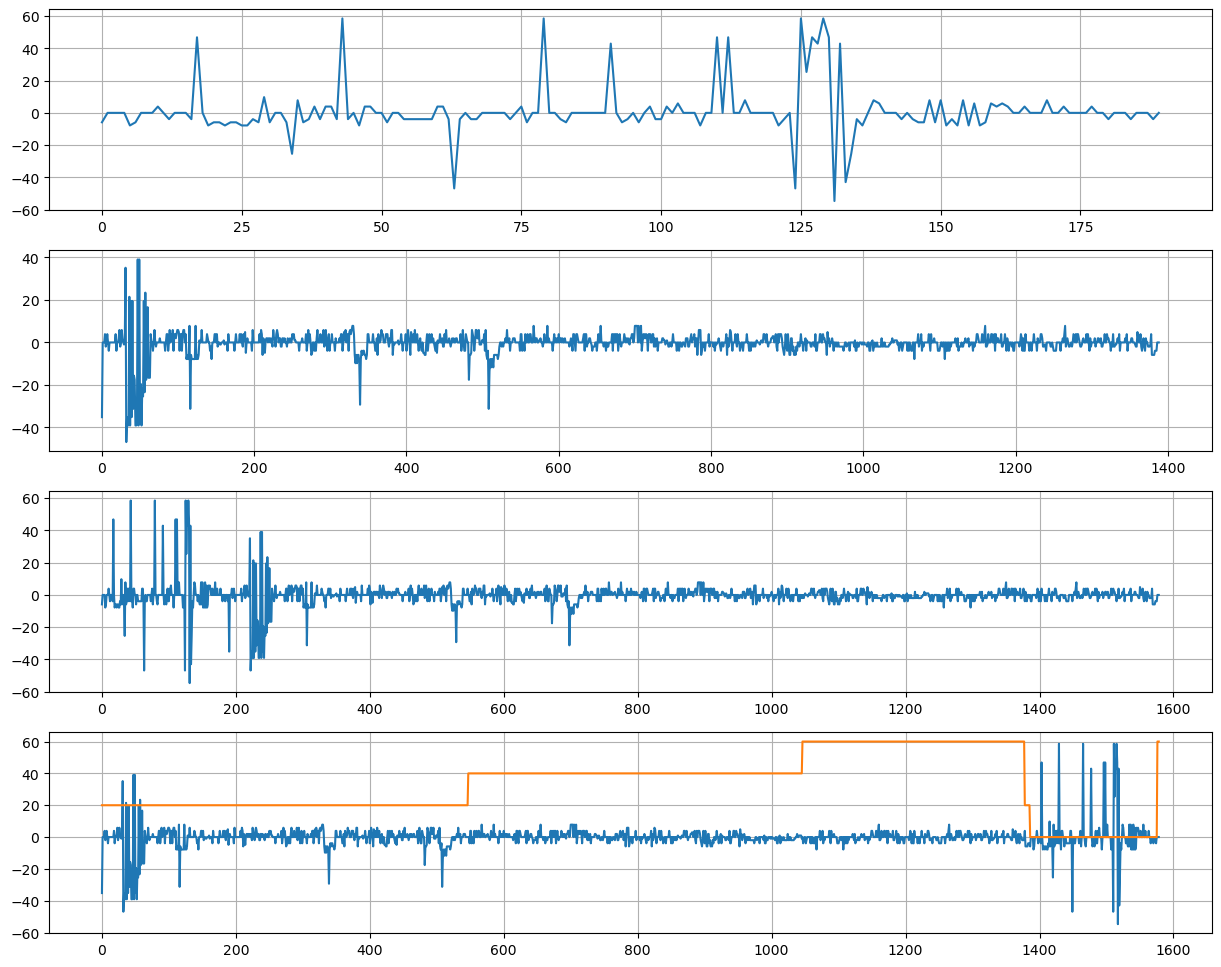


len =  4508


In [50]:
if TRAIN_MODE:
    targetLength = HISTORY_LEN

    df_sequence = df_train; df_base = df_train
    train_map = CREATE_MAP_v1(map_folder_path, map_filename_base, targetLength, df_sequence, df_base, year_span=SEQ_YEAR_SPAN, testcount=-1)

    print("\nlen = ", len(train_map))